# Preliminaries, requirements, imports, ...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import time
import cv2
import json

from tqdm.auto import tqdm
from pyttb.tensor import tensor as ttb

from video_handler import read_video_as_numpy
from rsvd import *
from tucker import *
from visualization import error_time_analysis

plt.rcParams['figure.figsize'] = [16,6]
plt.rcParams.update({'font.size': 18})

# Reading Video 

In [2]:
n_frames = 60
colorful = True
file_name = "ski"
input_folder = "../videos/input"
input_video_path =  input_folder + "/" + file_name + ".mp4"
exp_name = f"{file_name}{n_frames}{'' if colorful else '_gray'}"
fps = 20
format_ = "mp4v"

In [3]:
video_tensor = read_video_as_numpy(input_video_path, n_frames, colorful)

Reading first 60 frames from ../videos/input/ski.mp4:   0%|          | 0/60 [00:00<?, ?it/s]

Shape of read tensor = (60, 720, 1280, 3)


# Slicing + RSVD 

In [ ]:
results_rsvd = dict()
for comp_ratio in [2, 3, 5, 10, 25, 50]:
    print(f"===== COMPRESSION RATIO = {comp_ratio} =====")
    results_rsvd[comp_ratio] = all_dim_RSVD(exp_name=exp_name+f"_compress_{comp_ratio}",
                                            video_tensor=video_tensor,
                                            desired_compression_ratio=comp_ratio,
                                            format_=format_,
                                            fps=fps,
                                            colorful=colorful,
                                            delete_prev=True,
                                            save=True)
# dump only serializable parts (ignore sigmas and recontruction tensors)
json_res = results_rsvd.copy()
for key in json_res.keys():
    for non_series_key in ['reconstructed_tensors', 'sigmas']:
        json_res[key][non_series_key] = []
json_object = json.dumps(json_res, indent=4) 
# Writing to .json
with open(f"../jsons/{exp_name}.json", "w") as outfile:
    outfile.write(json_object)

# Tensor methods

## Tucker ALS

In [ ]:
results_tucker = dict()
for comp_ratio in [2, 3, 5, 10, 25, 50]:
    print(f"===== COMPRESSION RATIO = {comp_ratio} =====")
    results_tucker[comp_ratio] = decomposition_tucker(exp_name+f"_compress_{comp_ratio}", video_tensor, "TuckerALS", {"tol": 1e-3},
                                                desired_comp_ratio=comp_ratio,
                                                format_=format_,
                                                fps=fps,
                                                colorful=colorful,
                                                delete_prev=True)
# dump only serializable parts (ignore tensors)
json_res = results_tucker.copy()
for key in json_res.keys():
    for non_series_key in ['Tucker_reconstruction', 'dense_reconstruction']:
        json_res[key][non_series_key] = []
json_object = json.dumps(json_res, indent=4) 
# Writing to .json
with open(f"../jsons/Tucker_{exp_name}.json", "w") as outfile:
    outfile.write(json_object)

## HOSVD

In [ ]:
results_hosvd = dict()
for comp_ratio in [2, 3, 5, 10, 25, 50]:
    print(f"===== COMPRESSION RATIO = {comp_ratio} =====")
    results_hosvd[comp_ratio] = decomposition_tucker(exp_name+f"_compress_{comp_ratio}", video_tensor, "HOSVD", {"tol": 1e-3},
                                                desired_comp_ratio=comp_ratio,
                                                format_=format_,
                                                fps=fps,
                                                colorful=colorful,
                                                delete_prev=True)
# dump only serializable parts (ignore tensors)
json_res = results_hosvd.copy()
for key in json_res.keys():
    for non_series_key in ['Tucker_reconstruction', 'dense_reconstruction']:
        json_res[key][non_series_key] = []
json_object = json.dumps(json_res, indent=4) 
# Writing to .json
with open(f"../jsons/HOSVD_{exp_name}.json", "w") as outfile:
    outfile.write(json_object)

# Time and Error Analysis

                                                            ski60                                                            


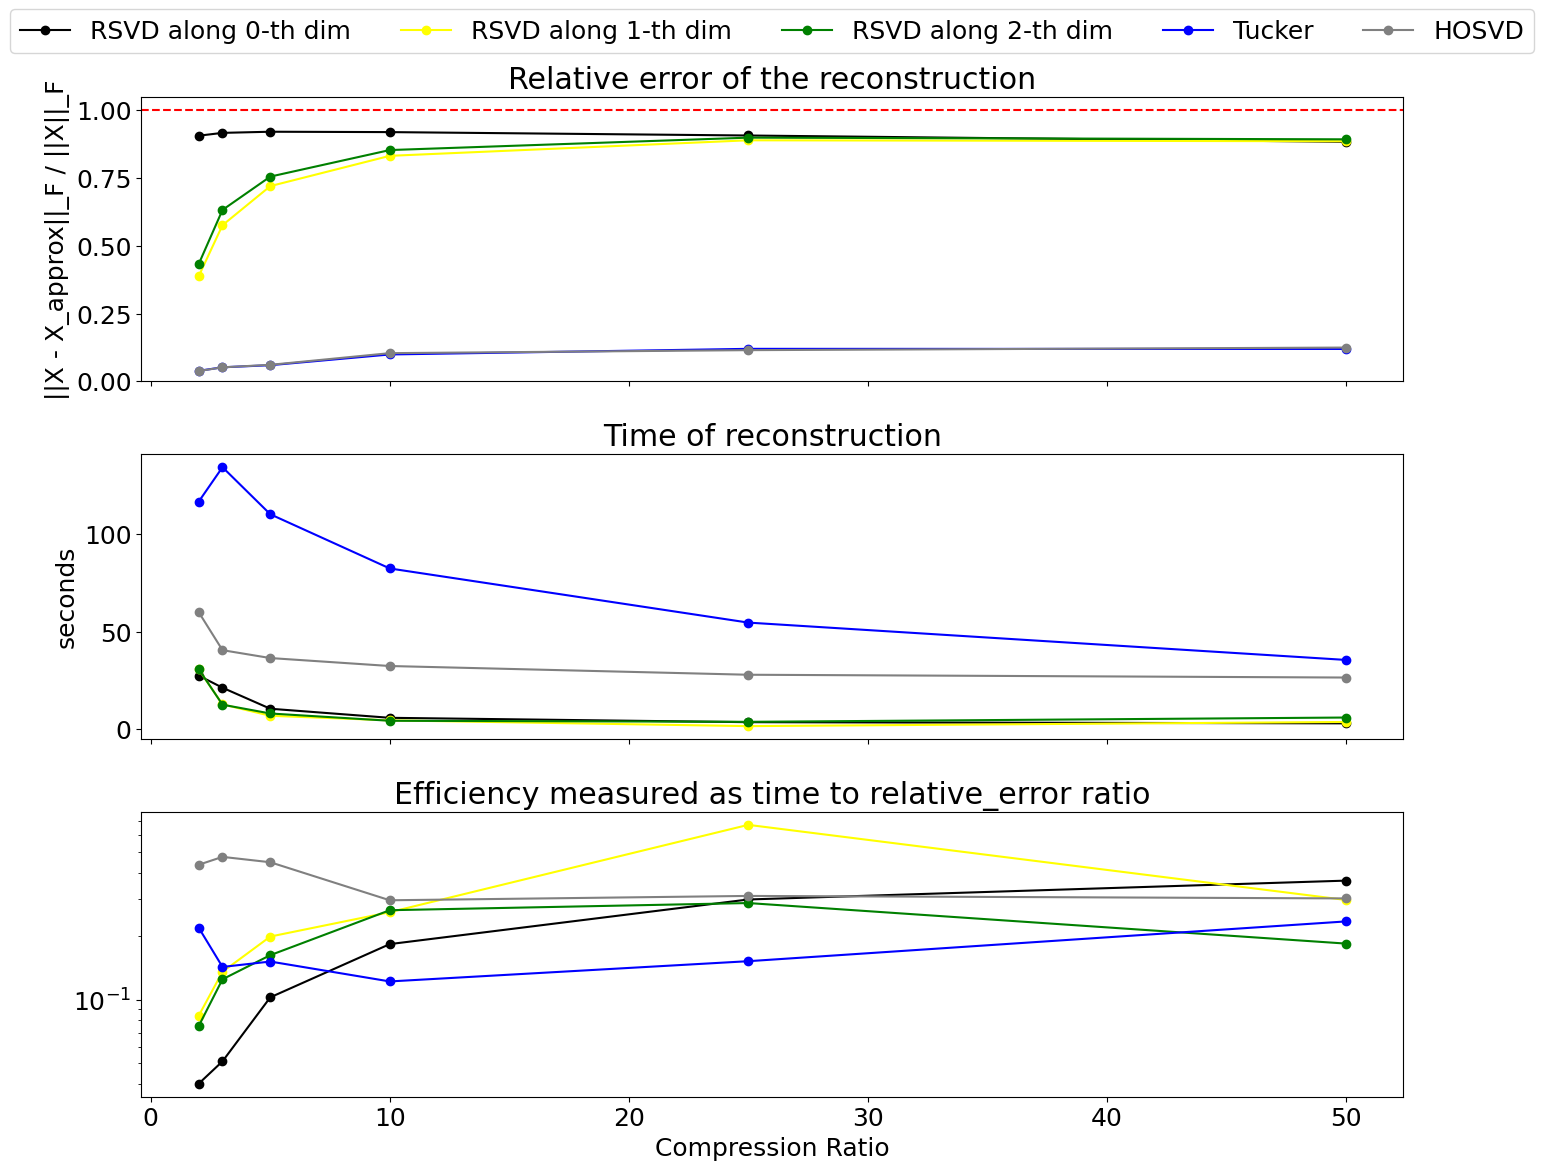

In [4]:
with open(f"../jsons/{exp_name}.json", "r") as openfile:
    results_RSVD = json.load(openfile) 

with open(f"../jsons/Tucker_{exp_name}.json", "r") as openfile:
    results_Tucker = json.load(openfile)

with open(f"../jsons/HOSVD_{exp_name}.json", "r") as openfile:
    results_HOSVD = json.load(openfile)
print(f"{exp_name: ^125}")
relative_errors, times, efficiency = error_time_analysis(exp_name, results_RSVD, results_Tucker, results_HOSVD, show_plot=True)